ID #1: 319238119

ID #2: 207576463

# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 319238119, 207576463

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x1071961c0>, <__main__.Node at 0x107196550>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
data.dropna(inplace=True)

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """

    _, counts = np.unique(data[:, -1], return_counts=True)
    gini = 1 - sum(map(lambda count: (count / sum(counts)) ** 2, counts))

    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.
    """

    _, counts = np.unique(data[:, -1], return_counts=True)
    entropy = sum(map(lambda count: - (count / sum(counts)) * math.log2(count / sum(counts)) , counts))

    return entropy

In [10]:
X_all_e_class = X[X[:, -1] == "e", :]
print(f'When the class of all instances is "e" we get calc_gini = {calc_gini(X_all_e_class)}')
print(f'When the class of all instances is "e" we get calc_entropy = {calc_entropy(X_all_e_class)}')
X_all_p_class = X[X[:, -1] == "p", :]
print(f'When the class of all instances is "p" we get calc_gini = {calc_gini(X_all_p_class)}')
print(f'When the class of all instances is "p" we get calc_entropy = {calc_entropy(X_all_p_class)}')
print(f'When the instances are split equally between "e" and "p" we get calc_gini = {calc_gini(np.append(X_all_e_class[0:9, :], X_all_p_class[0:9, :], axis=0))}')
print(f'When the instances are split equally between "e" and "p" we get calc_entropy = {calc_entropy(np.append(X_all_e_class[0:9, :], X_all_p_class[0:9, :], axis=0))}')
print(f'gini on X = {calc_gini(X)}')
print(f'Entropy on X = {calc_entropy(X)}')

When the class of all instances is "e" we get calc_gini = 0.0
When the class of all instances is "e" we get calc_entropy = 0.0
When the class of all instances is "p" we get calc_gini = 0.0
When the class of all instances is "p" we get calc_entropy = 0.0
When the instances are split equally between "e" and "p" we get calc_gini = 0.5
When the instances are split equally between "e" and "p" we get calc_entropy = 1.0
gini on X = 0.4995636322379775
Entropy on X = 0.9993703627906085


## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [11]:
def goodness_of_split_internal(data, feature, impurity_func):
    data_impurity = impurity_func(data)
    impurity_sum = 0
    feature_values = set(data[:, feature])
    for feature_value in feature_values:
        instances = data[data[:, feature] == feature_value]
        impurity_sum += (instances.shape[0] / data.shape[0]) * impurity_func(instances)
    return data_impurity - impurity_sum


def calc_split_information(data, feature):
    _, counts = np.unique(data[:, feature], return_counts=True)
    split_information = sum(map(lambda count: - (count / sum(counts)) * math.log2(count / sum(counts)) , counts))
    return split_information


def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """

    if not gain_ratio:
        return goodness_of_split_internal(data, feature, impurity_func)
    else:
        information_gain = goodness_of_split_internal(data, feature, impurity_func=calc_entropy)
        split_information = calc_split_information(data, feature)
        return information_gain / split_information

In [12]:
# Test for goodness_of_split

X_goodness_test = np.array([['g', 'e', 'c', 'a'],
                            ['g', 'f', 'c', 'a'],
                            ['g', 'e', 'd', 'b'],
                            ['h', 'f', 'd', 'b']])

print(f'Goodness of split by feature 2 should be highest.')
print(f'Entropy: {round(goodness_of_split(X_goodness_test, feature=2, impurity_func=calc_entropy), 2)}, Gini: {round(goodness_of_split(X_goodness_test, feature=2, impurity_func=calc_gini), 2)}, Gain Ratio: {round(goodness_of_split(X_goodness_test, feature=2, impurity_func=calc_entropy, gain_ratio=True), 2)}')
print(f'Goodness of split by feature 1 should be lowest.')
print(f'Entropy: {round(goodness_of_split(X_goodness_test, feature=1, impurity_func=calc_entropy), 2)}, Gini: {round(goodness_of_split(X_goodness_test, feature=1, impurity_func=calc_gini), 2)}, Gain Ratio: {round(goodness_of_split(X_goodness_test, feature=1, impurity_func=calc_entropy, gain_ratio=True), 2)}')
print(f'Goodness of split by feature 0 should be somewhere in the middle.')
print(f'Entropy: {round(goodness_of_split(X_goodness_test, feature=0, impurity_func=calc_entropy), 2)}, Gini: {round(goodness_of_split(X_goodness_test, feature=0, impurity_func=calc_gini), 2)}, Gain Ratio: {round(goodness_of_split(X_goodness_test, feature=0, impurity_func=calc_entropy, gain_ratio=True), 2)}')

Goodness of split by feature 2 should be highest.
Entropy: 1.0, Gini: 0.5, Gain Ratio: 1.0
Goodness of split by feature 1 should be lowest.
Entropy: 0.0, Gini: 0.0, Gain Ratio: 0.0
Goodness of split by feature 0 should be somewhere in the middle.
Entropy: 0.31, Gini: 0.17, Gain Ratio: 0.38


## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [13]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, data, depth, feature_value):
        self.data = data
        self.depth = depth # depth of the node, root depth is 0
        self.feature_value = feature_value # the value used for the split in the parent node
        self.feature_index = None # the feature that is used for the split in the curr node, determined when the node is developed
        self.children = []

        uniques = np.unique(data[:, -1], return_counts=True)
        self.pred = uniques[0][np.where(uniques[1].max() == uniques[1])[0][0]]

    def add_child(self, node):
        self.children.append(node)

    def set_feature_index(self, feature_index):
        self.feature_index = feature_index # column index of criteria being tested

In [14]:
def is_pure(data):
    return len(set(data[:, -1])) == 1


def find_best_feature_for_split(data, impurity, gain_ratio, used_features):
    max_goodness = -1
    best_feature = None
    for i in range(data.shape[1] - 1):
        if i in used_features:
            continue
        goodness = goodness_of_split(data, i, impurity, gain_ratio)
        if goodness > max_goodness:
            max_goodness = goodness
            best_feature = i
    return best_feature

def build_tree_internal(node, impurity, gain_ratio, min_samples_split, max_depth, used_features):
    if min_samples_split > node.data.shape[0]:
        return
    if node.depth == max_depth:
        return
    if is_pure(node.data):
        return
    feature = find_best_feature_for_split(node.data, impurity, gain_ratio, used_features)
    used_features.add(feature)
    node.set_feature_index(feature)
    feature_values = set(node.data[:, feature])
    for feature_value in feature_values:
        child_data = node.data[node.data[:, feature] == feature_value]
        child = DecisionNode(child_data, node.depth + 1, feature_value)
        node.add_child(child)
        build_tree_internal(child, impurity, gain_ratio, min_samples_split, max_depth, used_features)
    used_features.remove(feature)
    return

def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = DecisionNode(data=data, depth=0, feature_value=None)
    used_features = set()
    build_tree_internal(root, impurity, gain_ratio, min_samples_split, max_depth, used_features)
    return root

In [15]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [16]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    
    value = instance[node.feature_index]
    feature_values = [child.feature_value for child in node.children]

    while value in feature_values:
        for child in node.children:
            if child.feature_value == value:
                break
        node = child
        value = instance[node.feature_index]
        feature_values = [child.feature_value for child in node.children]
        
    return node.pred

In [17]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    
    for i in range(dataset.shape[0]):
        pred_val = predict(node, dataset[i, :])
        if pred_val == dataset[i, -1]:
            accuracy += 1
        
    accuracy = 100 * accuracy / dataset.shape[0]

    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [18]:
accuracy_gini = calc_accuracy(tree_gini, X_train)
print(f"Gini tree accuracy on train set is: {accuracy_gini:.2f}%")
accuracy_gini = calc_accuracy(tree_gini, X_test)
print(f"Gini tree accuracy on test set is: {accuracy_gini:.2f}%\n")

accuracy_entropy = calc_accuracy(tree_entropy, X_train)
print(f"Entrpy tree accuracy on train set is: {accuracy_entropy:.2f}%")
accuracy_entropy = calc_accuracy(tree_entropy, X_test)
print(f"Entrpy tree accuracy on test set is: {accuracy_entropy:.2f}%\n")

accuracy_entropy_gain_ratio = calc_accuracy(tree_entropy_gain_ratio, X_train)
print(f"Entropy - Gain ratio tree accuracy on train set is: {accuracy_entropy_gain_ratio:.2f}%")
accuracy_entropy_gain_ratio = calc_accuracy(tree_entropy_gain_ratio, X_test)
print(f"Entropy - Gain ratio tree accuracy on test set is: {accuracy_entropy_gain_ratio:.2f}%")


Gini tree accuracy on train set is: 100.00%
Gini tree accuracy on test set is: 77.25%

Entrpy tree accuracy on train set is: 100.00%
Entrpy tree accuracy on test set is: 77.15%

Entropy - Gain ratio tree accuracy on train set is: 100.00%
Entropy - Gain ratio tree accuracy on test set is: 78.53%


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

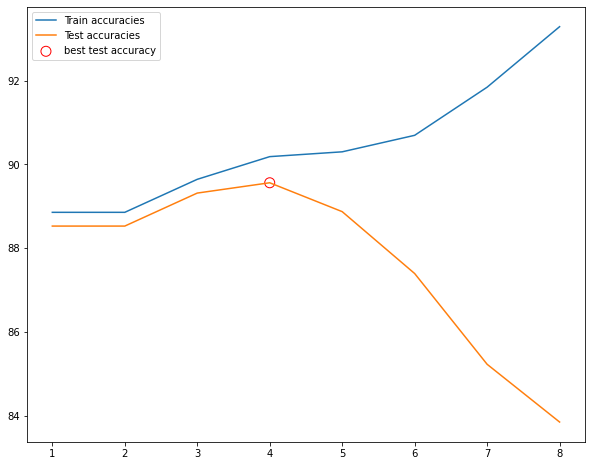

In [19]:
depths = [1, 2, 3, 4, 5, 6, 7, 8]

train_accuracies = []
test_accuracies = []

for depth in depths:
    tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=depth)
    train_accuracy = calc_accuracy(tree, X_train)
    test_accuracy = calc_accuracy(tree, X_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

fig, ax = plt.subplots()
ax.plot(depths, train_accuracies, label = 'Train accuracies')
ax.plot(depths, test_accuracies, label = 'Test accuracies')
plt.scatter(test_accuracies.index(max(test_accuracies)) + 1 , max(test_accuracies) , s=100 ,  facecolors='none', edgecolors='r' , label = 'best test accuracy') 
ax.legend()
plt.show(fig)

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

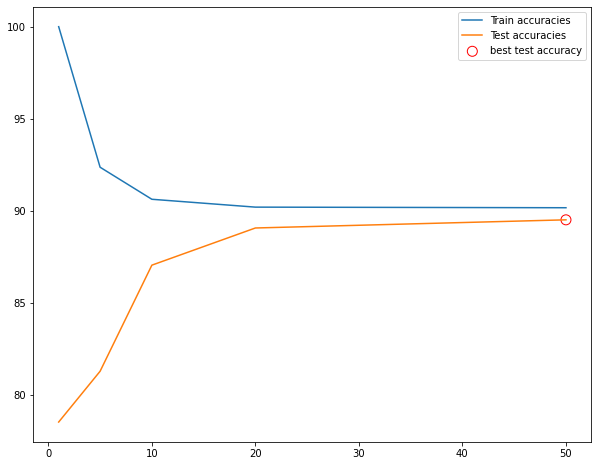

In [20]:
min_samples_splits = [1, 5, 10, 20, 50]

train_accuracies = []
test_accuracies = []

for min_samples in min_samples_splits:
    tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=min_samples)
    train_accuracy = calc_accuracy(tree, X_train)
    test_accuracy = calc_accuracy(tree, X_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

fig, ax = plt.subplots()
ax.plot(min_samples_splits, train_accuracies, label = 'Train accuracies')
ax.plot(min_samples_splits, test_accuracies, label = 'Test accuracies')
plt.scatter(min_samples_splits[test_accuracies.index(max(test_accuracies))] , max(test_accuracies) , s=100 ,  facecolors='none', edgecolors='r' , label = 'best test accuracy') 
ax.legend()
plt.show(fig)

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [21]:
tree_max_depth = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=4)
tree_min_samples_split= build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=50)


## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [ ]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [ ]:
def print_tree(node, parent_feature='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    spaces = '  ' * node.depth
    if len(node.children) == 0:
        values, counts = np.unique(node.data[:, -1], return_counts=True)
        values_message = ''
        for i in range(len(values)):
            values_message = values_message + values[i] + ':' + str(counts[i])
        values_message = '{' + values_message + '}'
        print(f'{spaces}[{parent_feature}, leaf]: [{values_message}]')
    else:
        print(f'{spaces}[{parent_feature}, feature={node.feature_index}]')
        for child in node.children:
            print_tree(child, f'X{node.feature_index}={child.feature_value}')

# TODO(slava): remove this statement
print_tree(tree_gini)

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [ ]:
#### Your code here ####
